<img src=../figures/Brown_logo.svg width=50%>

## Data-Driven Design & Analyses of Structures & Materials (3dasm)

## Lecture 22

### Miguel A. Bessa | <a href = "mailto: miguel_bessa@brown.edu">miguel_bessa@brown.edu</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the '3dasm' mamba (or conda) environment (see Lecture 1).
2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
    - Note: if you can't pull the repo due to conflicts (and you can't handle these conflicts), use this command (with **caution**!) and your repo becomes the same as the one online:
        ```
        git reset --hard origin/main
        ```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
jupyter notebook
```
5. Open notebook of this Lecture and choose the '3dasm' kernel.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Introduction to Artificial Neural Networks

**Reading material**: This notebook + (ANNs in Chapter 13)

## Today is our first lecture on artificial neural networks

We will introduce the basic idea behind **Artificial Neural Networks** (ANNs), and we will continue to refine these ideas in the next lectures.

In [2]:
from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)

n_data = 50 # number of points in our dataset
testset_ratio = 0.90 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_data, test_size=testset_ratio,
                                    random_state=seed)

x_train = X_train.ravel() # just for plotting later
x_test = X_test.ravel() # just for plotting later

print("Here's a print of X_train:\n", X_train)

Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


In [3]:
# Now let's also create the noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape) # np.random.random returns random number between [0.0, 1.0)
noise = np.random.normal(0, random_std) # sample vector from Gaussians with random standard deviation
y_noisy_data = y_data + noise # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?
# NOTE: since we are using the same seed and we do train_test_split on the same X_data and since y_noisy_data
#       is just y_data + noise, we are splitting the dataset exactly in the same way! This is nice because we
#       want to keep the comparison as fair as possible.

# Finally, for plotting purposes, let's convert the 2D arrays into 1D arrays (vectors):
x_train = X_train.ravel()
x_test = X_test.ravel()
y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

print("Note that X_train and X_test are the same data that we used for the noiseless case.")
print("Here's a print of X_train:\n", X_train)

Note that X_train and X_test are the same data that we used for the noiseless case.
Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


## Short tutorial on 1D regression with Artificial Neural Networks

ANNs for regression are not that different when compared to linear regression.

Consider again the observation distribution as we wrote it in the beginning of the course:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

But now, instead of modeling the mean of the distribution using polynomial basis functions by $f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x)$, consider a simple extension where the **basis functions also have their own parameters**:

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

where $\mathbf{z} = (\mathbf{z}_1,\, \mathbf{z}_2)$ and $\mathbf{z}_1 = (\mathbf{w},\, \mathbf{b})$ are all the parameters of the model.

Instead of stopping here,

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

we can also repeat this recursively $L$ times to create more complex transformations:

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(x\right)\right)\cdots\right)\right)
$$

where $f_l(x) = f(x;\, \mathbf{z}_l)$ is the function at layer $l$ of our recursive transformation.

This is the key idea behind **deep neural networks**.

* Confused?

Let's try to see this for a very simple case. Consider again the observation distribution:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

The simplest extension comes from using a nonlinear function $f_1$ acting on our well-known linear model:

$$
\mu_{y|z} = f(x;\, \mathbf{z}) = f_1\left( \mathbf{w}^T \boldsymbol{\phi}(x) \right) = f_1\left( f_0 \left(x; \mathbf{z}_0 \right) \right) = f_1\left(b_0 + w_0 x\right)
$$

where we are calling our linear regression model as $f_0 \left(x; \mathbf{z}_0 \right)$.

So, our model for the mean of the observation distribution becomes:

$$
\mu_{y|z} = f_1\left( b_0 + w_0 x \right)
$$

Does this remind you of a model we discussed before?

* If $f_1$ is the sigmoid function, then this is what we used in Logistic Regression!
    * Of course, in that case, the observation distribution was the Bernoulli distribution (instead of the Gaussian distribution) because it was a classification problem, and the mean was the $\rho$ parameter. 

Anyway, back to our model for the mean of our Gaussian observation distribution:

$$
\mu_{y|z} = f_1\left( b_0 + w_0 x \right)
$$

Why stop here?

Why not introducing more parameters?

$$
\mu_{y|z} = b_1 + w_1 f_1\left( b_0 + w_0 x \right)
$$

But why stop here?

What if we apply another nonlinear function $f_2$?

$$
\mu_{y|z} = f_2\left(b_1 + w_1 f_1\left( b_0 + w_0 x \right)\right)
$$

But why stop here?

What about doing this recursively $L$ times to create more complex transformations?

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(b_0 + w_0 x\right)\right)\cdots\right)\right)
$$

This is one of the simplest examples of an Artificial Neural Network architecture called feedforward architecture.

We will look into this model carefully in the next lectures.

For now, I just want to draw a schematic so that you understand the number of parameters that starts appearing!

* Draw on the board a feedforward ANN with 2 hidden layers for 1D case.
    * First hidden layer with 3 neurons and second hidden layer with 2 neurons.

Two examples of nonlinear activation functions $f_l$ for a layer $l$.


<div>
<img style="float: left"; src=../figures/nonlin_fn.png width=500px></div>

Let's now focus on how to create an ANN model for 1D regression using:
1. A feedforward architecture with 2 dense hidden layers
2. The ReLu activation function
3. Adam optimizer

In [4]:
# Let's create a function defining our Artificial Neural Network.
from tensorflow import keras # fast library for ANNs
from tensorflow.keras.optimizers import Adam # import the optimizer you want to use to calculate the parameters
from keras.models import Sequential # to create a feedforward neural network
from keras.layers import Dense # to create a feedforward neural network with dense layers
#
# Function to create the ANN model (in this case we are creating )
def create_ANN(input_dimensions=1, # number of input variables
               neurons1=3, # number of neurons in first hidden layer
               neurons2=2, # number of neurons in second hidden layer
               activation='relu', # activation function
               optimizer='adam'): # optimization algorithm to compute the weights and biases
    # create model
    model = Sequential() # Feedforward architecture
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(1)) # output layer with just one neuron because we have only one output (1D problem!)
    model.compile(loss='mse', # error metric to measure our NLL (loss)
                  optimizer=optimizer)
    return model

2024-09-03 20:07:35.010046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 20:07:35.019436: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 20:07:35.022284: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 20:07:35.029325: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 20:07:35.646044: W tensorflow/compiler/tf2

In addition, let's introduce something important: dataset preprocessing.

Standardizing our dataset is good practice and can be important for many ML algorithms (ANNs included).

In [5]:
# Standardizing your dataset is good practice and can be important for ANNs!
from sklearn.preprocessing import StandardScaler # standardize the dataset with scikit-learn
#
scaler = StandardScaler().fit(X_train) # Check scikit-learn to see what this does!
#
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_data_scaled=scaler.transform(X_data)
#

In [6]:
import scikeras
from scikeras.wrappers import KerasRegressor
#from tensorflow.keras import KerasRegressor # a new version will use scikeras
# Now create your first ANN model!
neurons1=200 # number of neurons for the first hidden layer
neurons2=10 # number of neurons for the second hidden layer
batch_size = len(X_train) # considering the entire dataset for updating the weights and biases in each epoch
epochs = 150 # number of times we train the neural network with the entire training set
optimizer = Adam(learning_rate=0.001) # specifying the learning rate value for the optimizer (PLAY WITH THIS!)
ANN_model = KerasRegressor(model=create_ANN, neurons1=neurons1, neurons2=neurons2,
                           batch_size=batch_size, epochs=epochs, optimizer=optimizer)

I0000 00:00:1725408456.233247  246197 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725408457.598824  246197 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725408457.598999  246197 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725408457.600159  246197 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [7]:
# Now that we created our first ANN model, let's fit it to our (scaled) dataset!
history = ANN_model.fit(X_train_scaled, y_train, validation_data=(scaler.transform(X_test), y_test))

/home/mbessa/mambaforge/envs/3dasm_new2/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150


I0000 00:00:1725408459.383408  246868 service.cc:146] XLA service 0x7fa304005ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725408459.383457  246868 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-09-03 20:07:39.435606: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-03 20:07:39.585599: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 17.6097

I0000 00:00:1725408460.530569  246868 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 17.6097 - val_loss: 13.9592
Epoch 2/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 17.5119 - val_loss: 13.9363
Epoch 3/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 17.4155 - val_loss: 13.9152
Epoch 4/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 17.3216 - val_loss: 13.8960
Epoch 5/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 17.2360 - val_loss: 13.8786
Epoch 6/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 17.1489 - val_loss: 13.8635
Epoch 7/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 17.0599 - val_loss: 13.8531
Epoch 8/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 16.9692 - val_loss: 13.8424
Epoch 9/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 16.8924 - val_loss: 13.8292
Epoch 10/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 16.8116 - val_loss: 13.8159
Epoch 11/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 16.7284 - val_loss: 13.8025
Epoch 12/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 16.6436

Epoch 69/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.7163 - val_loss: 12.9114
Epoch 70/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.5563 - val_loss: 12.8963
Epoch 71/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.3947 - val_loss: 12.8807
Epoch 72/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.2322 - val_loss: 12.8646
Epoch 73/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 9.0710 - val_loss: 12.8493
Epoch 74/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.9074 - val_loss: 12.8344
Epoch 75/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 8.7444 - val_loss: 12.8194
Epoch 76/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.5817 - val_loss: 12.8049
Epoch 77/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 8.4182 - val_loss: 12.7908
Epoch 78/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.2542 - val_loss: 12.7771
Epoch 79/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.0908 - val_loss: 12.7639
Epoch 80/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - l

Epoch 137/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.5315 - val_loss: 14.3154
Epoch 138/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.5141 - val_loss: 14.3424
Epoch 139/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4980 - val_loss: 14.3663
Epoch 140/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.4831 - val_loss: 14.3881
Epoch 141/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4677 - val_loss: 14.4091
Epoch 142/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.4531 - val_loss: 14.4290
Epoch 143/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4394 - val_loss: 14.4466
Epoch 144/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4261 - val_loss: 14.4626
Epoch 145/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.4133 - val_loss: 14.4748
Epoch 146/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.4003 - val_loss: 14.4839
Epoch 147/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.3882 - val_loss: 14.4898
Epoch 148/150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3

In [8]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(history.history_['loss']) # plot training loss
ax1_ANN.plot(history.history_['val_loss']) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=15)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_ANN.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # show testing data

y_pred = history.model_.predict(X_data_scaled) # predict all data points with ANN

ax2_ANN.plot(x_data, y_pred, 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=15)

# Create figure with specified size
fig_ANN.set_size_inches(16, 8)
plt.close(fig_ANN) # do not plot the figure now. We will show it in the next cell

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


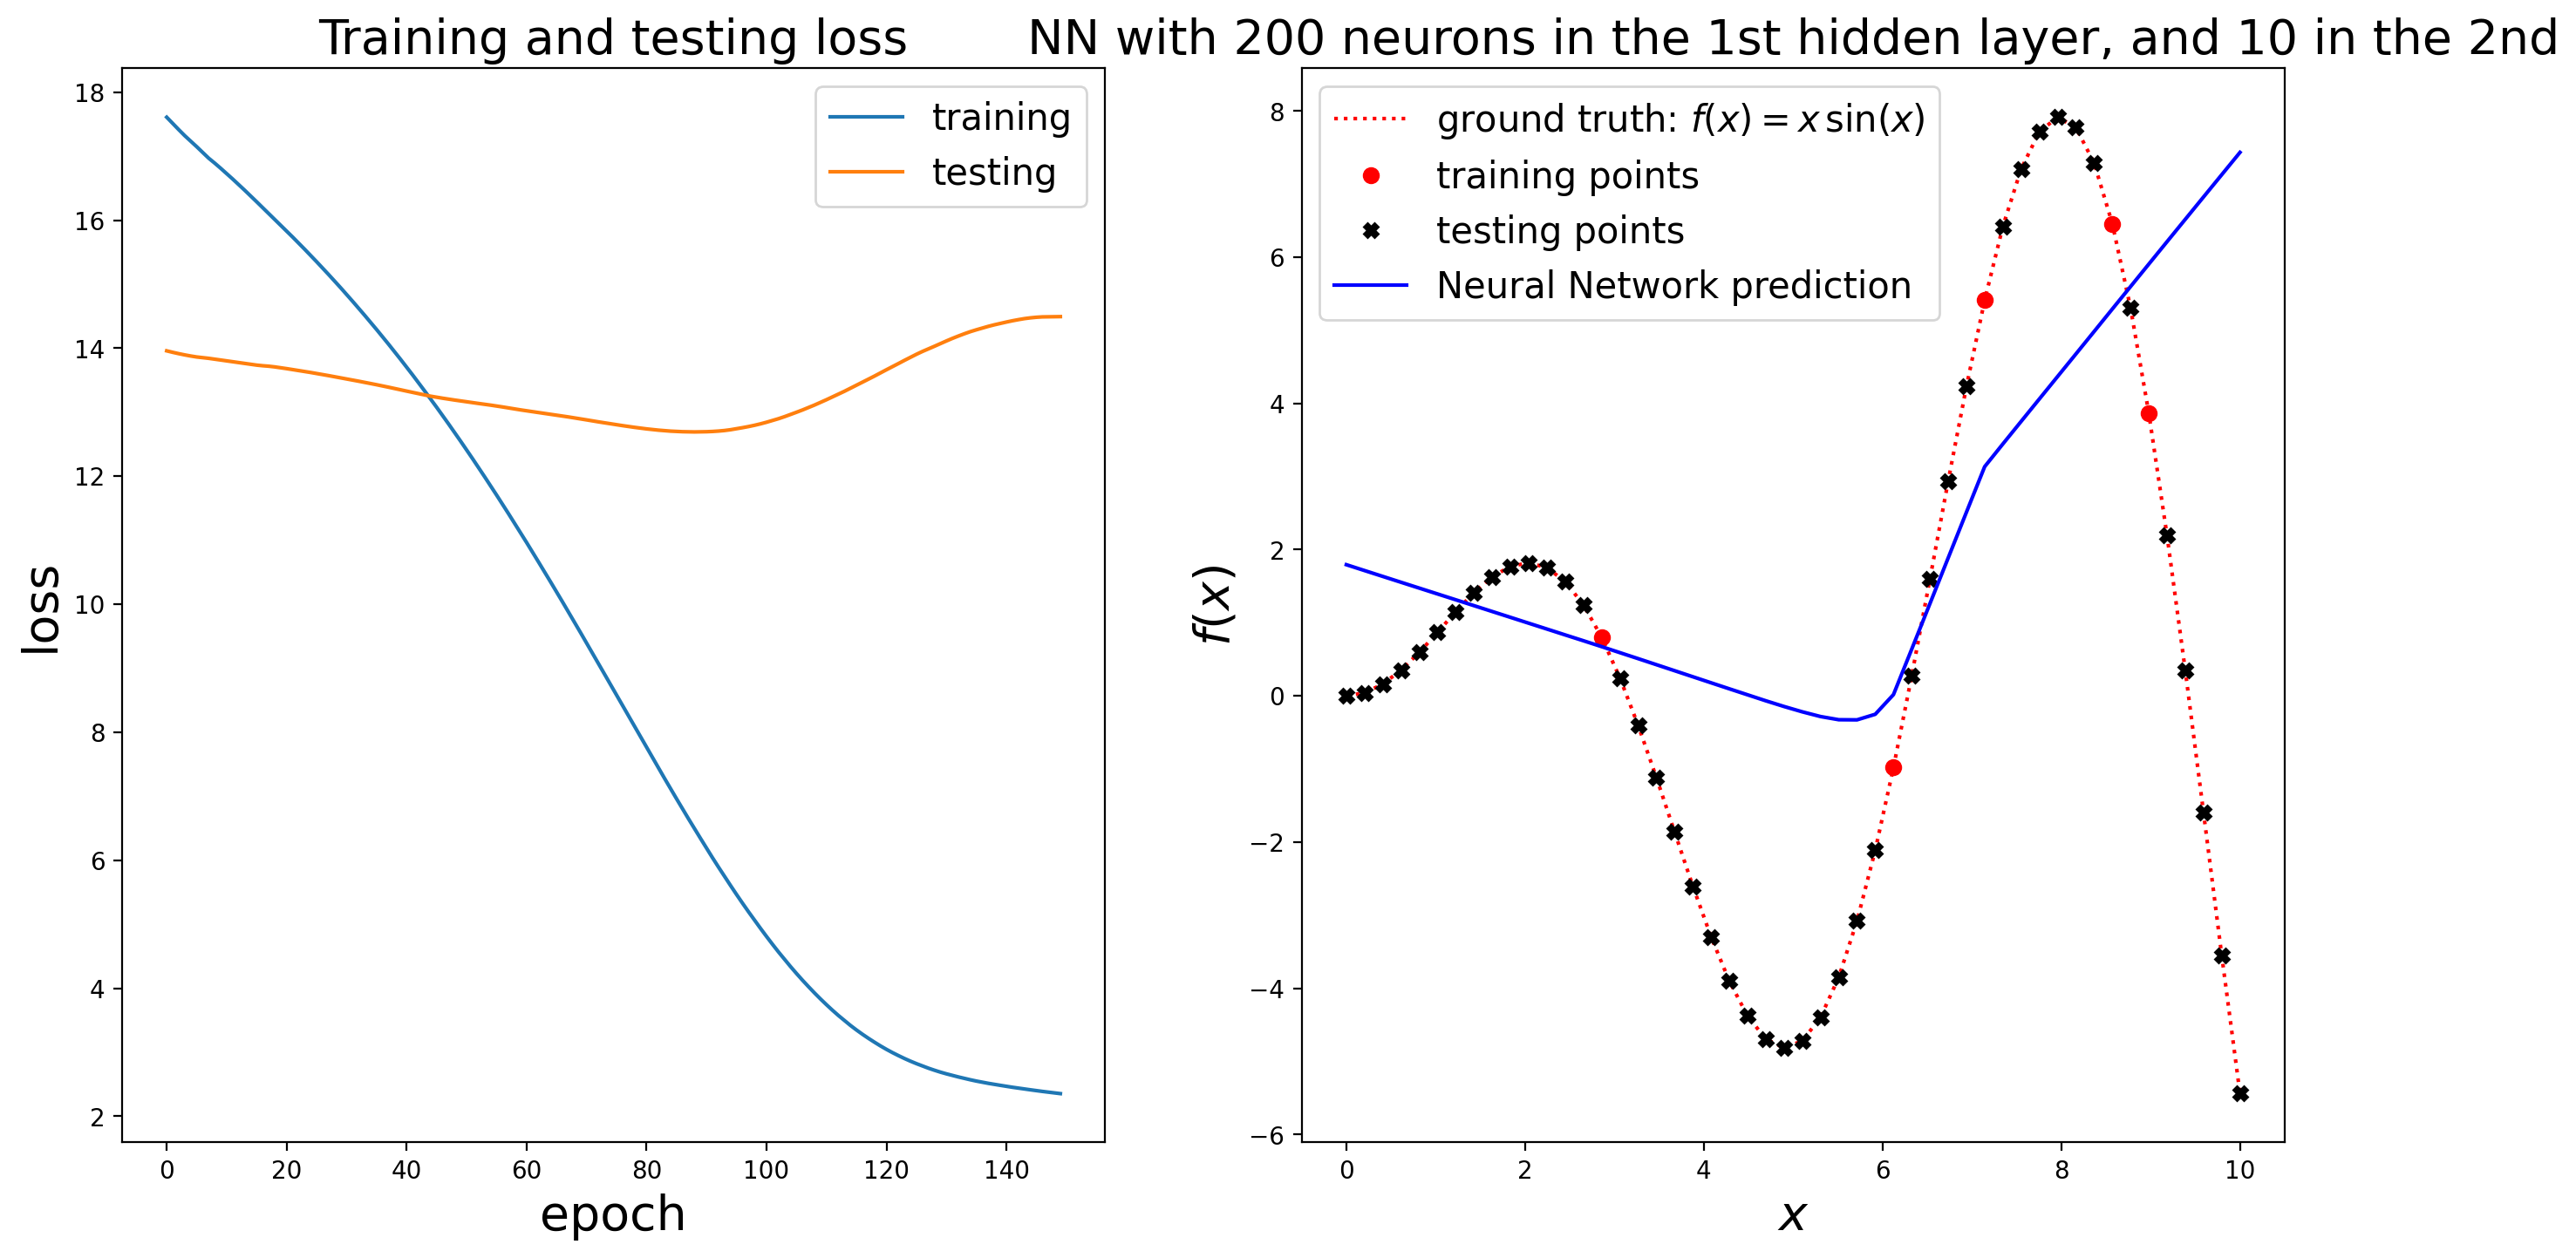

In [9]:
fig_ANN # show figure now.

Not the most amazing model you have ever seen, right?

* Try again but now using 200 neurons for the first hidden layer and 10 for the second hidden layer.
    - spoiler alert: a bit better, but far from amazing...

### See you next class

Have fun!